<a href="https://colab.research.google.com/github/chandini2595/FireSense/blob/main/Colab_Files/Amalgamation_DS1_DS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import pandas as pd

# Load DS2
file2_path = "/content/san_atonio_labeled_v2.csv"
df2 = pd.read_csv(file2_path)

# Select necessary columns (excluding date for merging)
ds2_selected_columns = [
    'latitude', 'longitude', 'temperature_2m', 'relative_humidity_2m',
    'precipitation', 'wind_speed_10m', 'cloud_cover', 'soil_temperature_0_to_7cm',
    'soil_moisture_0_to_7cm', 'forest_fire'
]

df2_selected = df2[ds2_selected_columns].copy()

# Handle missing values: Fill weather features with median values
weather_columns = [
    'temperature_2m', 'relative_humidity_2m', 'precipitation', 'wind_speed_10m',
    'cloud_cover', 'soil_temperature_0_to_7cm', 'soil_moisture_0_to_7cm'
]

for col in weather_columns:
    df2_selected[col].fillna(df2_selected[col].median(), inplace=True)

# Convert 'forest_fire' from categorical ('Y'/'N') to binary (1/0)
df2_selected['forest_fire'] = df2_selected['forest_fire'].map({'Y': 1, 'N': 0})


# Save cleaned DS2 (for merging without date)*
df2_selected.to_csv("/content/cleaned_ds2.csv", index=False)


<ipython-input-85-aa6c4c0f4f0e>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2_selected[col].fillna(df2_selected[col].median(), inplace=True)


In [86]:
print(df2_selected.isnull().sum())

latitude                     0
longitude                    0
temperature_2m               0
relative_humidity_2m         0
precipitation                0
wind_speed_10m               0
cloud_cover                  0
soil_temperature_0_to_7cm    0
soil_moisture_0_to_7cm       0
forest_fire                  0
dtype: int64


In [87]:
# Rename columns in DS1 to match DS2
df1.rename(columns={'lat': 'latitude', 'long': 'longitude'}, inplace=True)

# Save the updated DS1
df1.to_csv("/content/cleaned_ds1_fixed.csv", index=False)

# Print new column names to confirm changes
print("Updated Columns in DS1:", df1.columns)

Updated Columns in DS1: Index(['date', 'county', 'maxtempF', 'mintempF', 'avgtempF', 'totalSnow',
       'humid', 'wind', 'precip', 'q_avgtempF', 'q_avghumid', 'q_sumprecip',
       'sunHour', 'FIRE_NAME', 'CAUSE', 'latitude', 'longitude', 'GIS_ACRES'],
      dtype='object')


In [88]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Reload the cleaned DS1 and DS2
file1_path = "/content/cleaned_ds1_fixed.csv"
file2_path = "/content/cleaned_ds2.csv"

df1 = pd.read_csv(file1_path)
df2_selected = pd.read_csv(file2_path)

# Round latitude and longitude to improve matching
df1['latitude'] = df1['latitude'].round(3)
df1['longitude'] = df1['longitude'].round(3)
df2_selected['latitude'] = df2_selected['latitude'].round(3)
df2_selected['longitude'] = df2_selected['longitude'].round(3)

# Convert lat/lon to numpy arrays for fast lookup
ds1_coords = df1[['latitude', 'longitude']].dropna().to_numpy()
ds2_coords = df2_selected[['latitude', 'longitude']].dropna().to_numpy()

# Fit Nearest Neighbors model for DS2 locations
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(ds2_coords)
distances, indices = nbrs.kneighbors(ds1_coords)

# Map nearest DS2 location to DS1
df1 = df1.reset_index(drop=True)
df2_nearest = df2_selected.iloc[indices.flatten()].reset_index(drop=True)

# Merge datasets (DS1 + nearest DS2 match)
merged_knn_df = pd.concat([df1, df2_nearest.drop(columns=['latitude', 'longitude'])], axis=1)

# Save merged dataset
merged_knn_df.to_csv("/content/merged_ds1_ds2_knn.csv", index=False)

print("Merged DS1 and DS2 successfully using nearest neighbor location matching.")

Merged DS1 and DS2 successfully using nearest neighbor location matching.


In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged dataset
file_path = "/content/merged_ds1_ds2_knn.csv"
df = pd.read_csv(file_path)

# Selecting only relevant features from DS1 and DS2
selected_features = [
    'latitude', 'longitude', 'maxtempF', 'mintempF', 'avgtempF', 'totalSnow',
    'humid', 'wind', 'precip', 'sunHour', 'CAUSE', 'GIS_ACRES',
    'temperature_2m', 'relative_humidity_2m', 'precipitation', 'wind_speed_10m',
    'cloud_cover', 'soil_temperature_0_to_7cm', 'soil_moisture_0_to_7cm',
    'forest_fire'  # Target variable
]

# Keep only selected features
df_selected = df[selected_features]

# Save the feature-selected dataset
df_selected.to_csv("/content/selected_features_ds1_ds2.csv", index=False)

# Print the first few rows
print(df_selected.head())

# Check for missing values in the selected features
print("\nMissing Values in Selected Features:\n", df_selected.isnull().sum())

   latitude  longitude   maxtempF   mintempF   avgtempF  totalSnow      humid  \
0     34.54    -120.04  89.129032  59.709677  80.548387        0.0  41.451613   
1     38.18    -120.56  96.419355  51.290323  87.032258        0.0  33.580645   
2     38.18    -120.56  96.419355  51.290323  87.032258        0.0  33.580645   
3     38.18    -120.56  96.419355  51.290323  87.032258        0.0  33.580645   
4     38.18    -120.56  96.419355  51.290323  87.032258        0.0  33.580645   

       wind  precip    sunHour  CAUSE   GIS_ACRES  temperature_2m  \
0  7.354839     0.0  13.164516    0.0    0.000000          32.330   
1  5.387097     0.0  14.022581    1.0  176.763400          22.642   
2  5.387097     0.0  14.022581   10.0   73.444778          22.642   
3  5.387097     0.0  14.022581   14.0  101.074150          22.642   
4  5.387097     0.0  14.022581    6.0  103.968050          22.642   

   relative_humidity_2m  precipitation  wind_speed_10m  cloud_cover  \
0             22.189016    

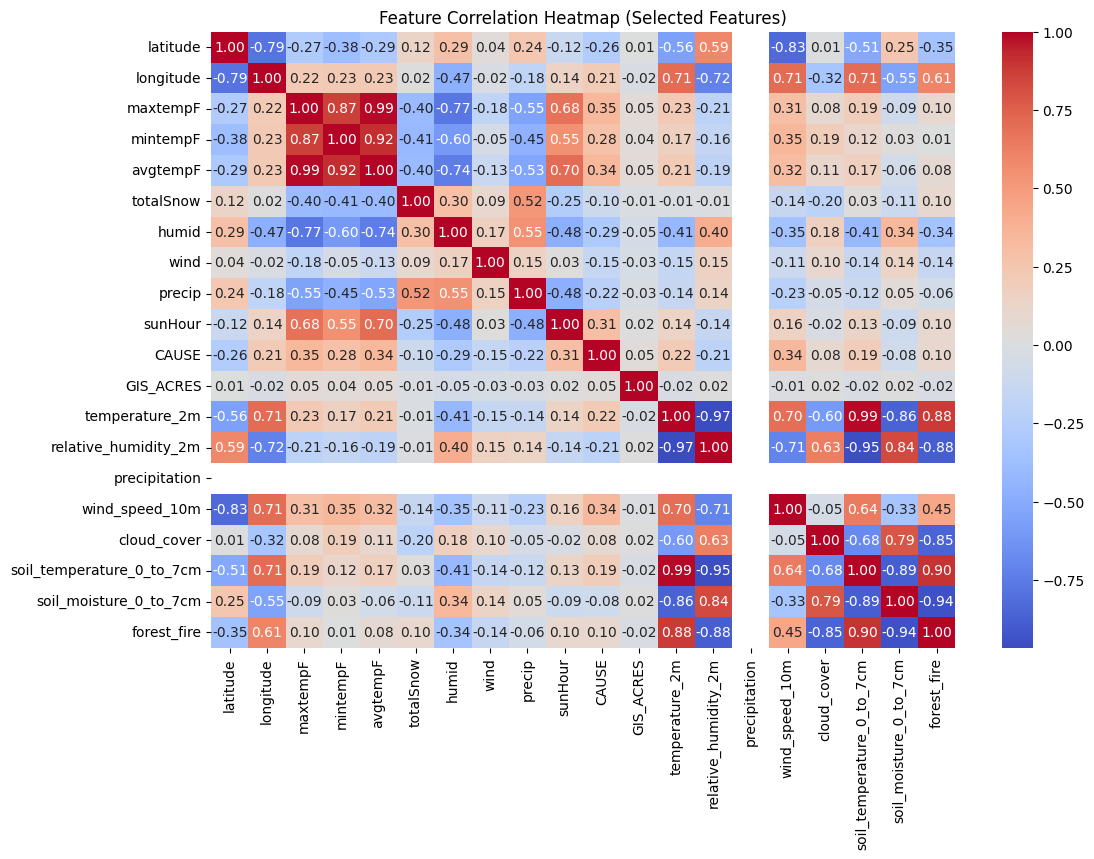


Top Features Correlated with Wildfire Occurrence:
 forest_fire                  1.000000
soil_moisture_0_to_7cm       0.939595
soil_temperature_0_to_7cm    0.904648
relative_humidity_2m         0.882824
temperature_2m               0.879575
cloud_cover                  0.853413
longitude                    0.608134
wind_speed_10m               0.446814
latitude                     0.345185
humid                        0.339975
wind                         0.137650
CAUSE                        0.097697
maxtempF                     0.097501
totalSnow                    0.096643
sunHour                      0.096428
avgtempF                     0.075975
precip                       0.064653
GIS_ACRES                    0.021409
mintempF                     0.009411
precipitation                     NaN
Name: forest_fire, dtype: float64


In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the selected feature dataset
file_path = "/content/selected_features_ds1_ds2.csv"
df_selected = pd.read_csv(file_path)

# Compute the correlation matrix
correlation_matrix = df_selected.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap (Selected Features)")
plt.show()

# Display top features most correlated with 'forest_fire'
correlation_with_target = correlation_matrix['forest_fire'].abs().sort_values(ascending=False)
print("\nTop Features Correlated with Wildfire Occurrence:\n", correlation_with_target)

In [91]:
import pandas as pd

# Load the selected feature dataset
file_path = "/content/selected_features_ds1_ds2.csv"
df_selected = pd.read_csv(file_path)

# Drop the 'precipitation' column
df_selected = df_selected.drop(columns=['precipitation'])

# Save the updated dataset
df_selected.to_csv("/content/updated_features_ds1_ds2.csv", index=False)

print("Updated dataset saved. 'precipitation' removed successfully.")

Updated dataset saved. 'precipitation' removed successfully.


In [92]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the updated dataset (without precipitation)
file_path = "/content/updated_features_ds1_ds2.csv"
df = pd.read_csv(file_path)

# Separate features (X) and target variable (y)
X = df.drop(columns=['forest_fire'])  # Features
y = df['forest_fire']  # Target (0 = No Fire, 1 = Fire)

# Standardize numerical features (scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into 80% training and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Store in DataFrames
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)
y_train_df = pd.DataFrame(y_train, columns=['forest_fire'])
y_test_df = pd.DataFrame(y_test, columns=['forest_fire'])

# Print dataset shapes
print("Training Set Shape:", X_train_df.shape, y_train_df.shape)
print("Testing Set Shape:", X_test_df.shape, y_test_df.shape)

Training Set Shape: (8790, 18) (8790, 1)
Testing Set Shape: (2198, 18) (2198, 1)


Model Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       491
           1       1.00      1.00      1.00      1707

    accuracy                           1.00      2198
   macro avg       1.00      1.00      1.00      2198
weighted avg       1.00      1.00      1.00      2198



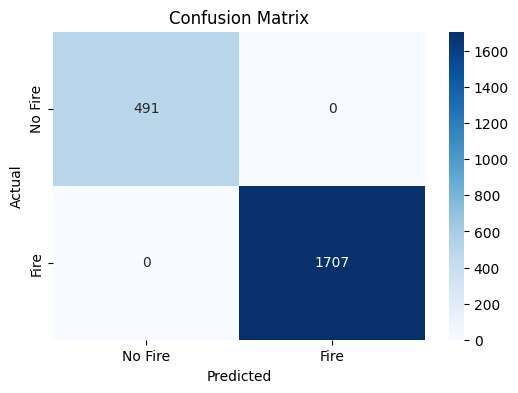

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_df, y_train_df.values.ravel())  # Using .values.ravel() to convert y_train_df to 1D

# Predict on test data
y_pred = rf_model.predict(X_test_df)

# Evaluate model performance
accuracy = accuracy_score(y_test_df, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:\n", classification_report(y_test_df, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_df, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fire", "Fire"], yticklabels=["No Fire", "Fire"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Updated Model Accuracy (Without GIS_ACRES): 1.0000
Cross-Validation Accuracy: 1.0000 ± 0.0000

Updated Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       491
           1       1.00      1.00      1.00      1707

    accuracy                           1.00      2198
   macro avg       1.00      1.00      1.00      2198
weighted avg       1.00      1.00      1.00      2198



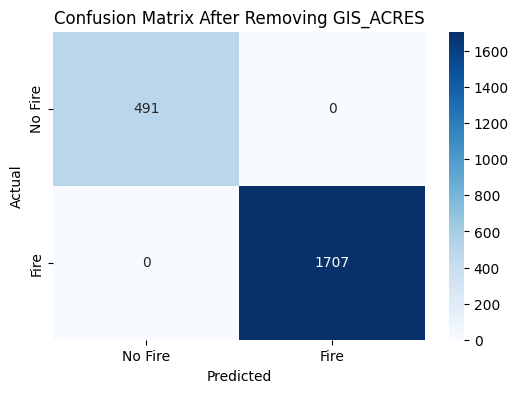

In [94]:
# Remove GIS_ACRES and retrain
X_filtered = X_train_df.drop(columns=['GIS_ACRES'], errors='ignore')
X_test_filtered = X_test_df.drop(columns=['GIS_ACRES'], errors='ignore')

# Train a new model without GIS_ACRES
rf_model_filtered = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=5, random_state=42)
rf_model_filtered.fit(X_filtered, y_train_df.values.ravel())

# Perform Cross-Validation
cv_scores_filtered = cross_val_score(rf_model_filtered, X_filtered, y_train_df.values.ravel(), cv=5)

# Predict on test data
y_pred_filtered = rf_model_filtered.predict(X_test_filtered)

# Evaluate updated model
accuracy_filtered = accuracy_score(y_test_df, y_pred_filtered)
print(f"Updated Model Accuracy (Without GIS_ACRES): {accuracy_filtered:.4f}")
print(f"Cross-Validation Accuracy: {np.mean(cv_scores_filtered):.4f} ± {np.std(cv_scores_filtered):.4f}")

# Classification report
print("\nUpdated Classification Report:\n", classification_report(y_test_df, y_pred_filtered))

# Confusion matrix
conf_matrix_filtered = confusion_matrix(y_test_df, y_pred_filtered)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_filtered, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fire", "Fire"], yticklabels=["No Fire", "Fire"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix After Removing GIS_ACRES")
plt.show()


Top Features Correlated with Wildfire Occurrence:
 forest_fire                  1.000000
soil_moisture_0_to_7cm       0.939595
soil_temperature_0_to_7cm    0.904648
relative_humidity_2m         0.882824
temperature_2m               0.879575
cloud_cover                  0.853413
longitude                    0.608134
wind_speed_10m               0.446814
latitude                     0.345185
humid                        0.339975
wind                         0.137650
CAUSE                        0.097697
maxtempF                     0.097501
totalSnow                    0.096643
sunHour                      0.096428
avgtempF                     0.075975
precip                       0.064653
GIS_ACRES                    0.021409
mintempF                     0.009411
Name: forest_fire, dtype: float64


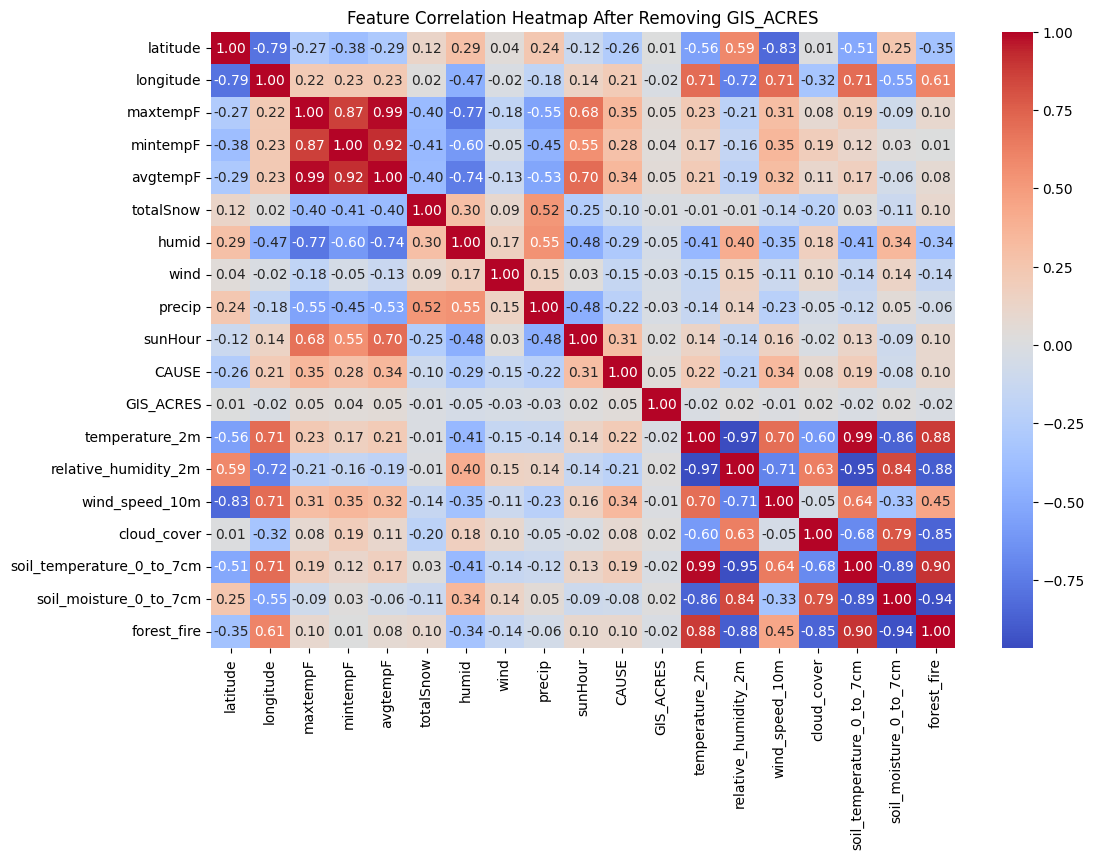

In [95]:
# Reload dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = "/content/updated_features_ds1_ds2.csv"
df = pd.read_csv(file_path)

# Compute correlation with 'forest_fire'
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['forest_fire'].abs().sort_values(ascending=False)

# Display top correlated features
print("\nTop Features Correlated with Wildfire Occurrence:\n", correlation_with_target)

# Plot heatmap again
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap After Removing GIS_ACRES")
plt.show()

In [100]:
# Features to remove (based on high correlation)
features_to_remove = [
    'soil_moisture_0_to_7cm', 'soil_temperature_0_to_7cm',
    'relative_humidity_2m', 'temperature_2m', 'cloud_cover'
]

# Remove high-correlation features
X_filtered = X_train_df.drop(columns=features_to_remove, errors='ignore')
X_test_filtered = X_test_df.drop(columns=features_to_remove, errors='ignore')

# Retrain model without high-correlation features
rf_model_filtered = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=5, random_state=42)
rf_model_filtered.fit(X_filtered, y_train_df.values.ravel())

# Perform Cross-Validation
cv_scores_filtered = cross_val_score(rf_model_filtered, X_filtered, y_train_df.values.ravel(), cv=5)

# Predict on test data
y_pred_filtered = rf_model_filtered.predict(X_test_filtered)



Logistic Regression Accuracy: 0.9813


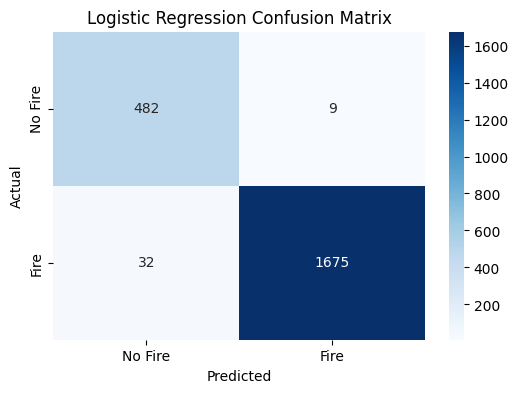

In [106]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
log_model = LogisticRegression(max_iter=50)
log_model.fit(X_filtered, y_train_df.values.ravel())

# Predict on test data
y_pred_log = log_model.predict(X_test_filtered)

# Evaluate model
accuracy_log = accuracy_score(y_test_df, y_pred_log)
print(f"Logistic Regression Accuracy: {accuracy_log:.4f}")

# Confusion matrix
conf_matrix_log = confusion_matrix(y_test_df, y_pred_log)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_log, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fire", "Fire"], yticklabels=["No Fire", "Fire"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()